In [2]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
from matplotlib.container import BarContainer
from matplotlib.ticker import FuncFormatter

def comma_formatter(x, pos):
    return f'{x:,.0f}'

def to_human(num, suffix="B"):
    if num % 1024 != 0:
        return f"{num}{suffix}"
    else:
        return pretty_fmt(num, suffix)

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

BENCHMARK_NAME="ior"
FIG_DIR = Path(f"../../fig/{BENCHMARK_NAME}").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    for ext in ('png', 'eps'):
        fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    # pass 


In [3]:
def load_ior_summary_list(json_file: Path):
    data = json.loads(json_file.read_text())
    return [
        {
            'Version': data['Version'],
            'Began': data['Began'],
            'Command line': data['Command line'],
            'Machine': data['Machine'],
            'Finished': data['Finished'],
            **{f'test_{k}': v for k, v in test.items() if k not in ["Results", "max", "Parameters", "Options"]},
            **{f"max_{k}": v for k, v in test["max"].items()},
            **{f"Parameters_{k}": v for k, v in test["Parameters"].items()},
            **{f"Options_{k}": v for k, v in test["Options"].items()},
            **{f'summary_{k}': v for k, v in data['summary'][index].items()},
            **{f'result_{k}': v for k, v in result.items()},
            'iorIteration': iteration,
        }
        for index, test in enumerate(data['tests'])
        for iteration, results in enumerate(test["Results"]) # iteration ?
        for result in results
    ]
# load_ior_summary_list(Path(f"../raw/{BENCHMARK_NAME}/2023.11.16-19.27.41/2023.11.16-20.03.19-92963.nqsv-bank-conflict-1/ior_summary_1.json"))


In [4]:
re_hook_pmembb = re.compile(r"hook:pmembb:rpmbb_store_(create|free|save|load) ([0-9]+\.[0-9]+)")
def df_extract_hook_pmembb_time(stderr_path: Path):
    text = stderr_path.read_text()
    matches = re_hook_pmembb.findall(text)
    return pd.DataFrame(matches, columns=["type", "time"])

def extract_hook_pmembb_time_max(stderr_path: Path):
    return (
        df_extract_hook_pmembb_time(stderr_path)
        .groupby("type")
        .max()
        .transpose()
        .rename(columns={
            "create": "createTime",
            "free": "freeTime",
            "save": "saveTime",
            "load": "loadTime",
        })
        .reset_index(drop=True)
        .astype(float)
        .loc[0,:]
        .to_dict()
    )

wpath = Path("../../raw/ior-pmembb/2024.01.23-15.22.18-default/2024.01.23-15.24.03-166930.nqsv-1/ior_stderr_8.txt")
rpath = Path("../../raw/ior-pmembb/2024.01.23-15.22.18-default/2024.01.23-15.24.03-166930.nqsv-1/ior_stderr_8.txt")
extract_hook_pmembb_time_max(rpath)


{'createTime': 14.976, 'freeTime': 0.023, 'loadTime': 0.005}

In [5]:
RAW_BASEDIR=Path(f"../../raw/")

default_metadata={
}

job_group = (
    ("ior-pmembb/2024.01.23-15.20.41-default", {}),
    ("ior-pmembb/2024.01.23-15.22.18-default", {}),
    ("ior-pmembb/2024.01.24-12.44.18-default", {}), # remain 100 node job
    # ("ior-pmembb/2024.01.24-13.37.36-no-deferred-open", {}), # backup
    # ("ior-pmembb/2024.01.24-15.43.39-no-deferred-open-1M", {}), # backup
    ("ior-pmembb/2024.01.26-18.12.56-open-eval", {}),
    ("ior-pmembb/2024.01.26-18.14.06-open-eval", {}),
    ("ior-pmembb/2024.03.13-11.17.33-47008", {}),
)

def job_dirs(job_group_dir: str):
    dir = RAW_BASEDIR / job_group_dir
    return (f.resolve() for f in dir.iterdir() if f.is_dir())

re_timestamp = re.compile(r'([0-9]{4})\.([0-9]{2})\.([0-9]{2})-([0-9]{2})\.([0-9]{2})\.([0-9]{2})')
def parse_job_start_timestamp(job_dir: Path):
    m = re_timestamp.search(str(job_dir))
    if m:
        return m.group()
    else:
        return None

re_runid = re.compile(r"_([0-9]+)\.json")
def get_runid(file: Path):
    m = re_runid.search(str(file))
    if m:
        return int(m.group(1))
    else:
        return None

# def get_runtype(file: Path):
#     strpath = str(file.name)
#     if strpath.find("_r_l_") >= 0:
#         return "r_l"
#     elif strpath.find("_r_") >= 0:
#         return "r"
#     elif strpath.find("_w_") >= 0:
#         return "w"
#     else:
#         raise Exception

def load_nodelist(job_dir: Path):
    with(job_dir / f"nodelist").open() as f:
        return list(map(lambda s: s.strip(), f.readlines()))

src = []
for job_group_dir,metadata in job_group:
    for job_dir in job_dirs(job_group_dir):
        try:
            job_start = {"job_start": parse_job_start_timestamp(job_dir)}
            job_nodelist = {"nodelist": load_nodelist(job_dir)}
        except Exception as e:
            print(f"{job_dir}, {e}")
        for summary_file in job_dir.glob("ior_summary_*.json"):
            try:
                runid = get_runid(summary_file)
                # runtype = get_runtype(summary_file)
                job_summary_list = load_ior_summary_list(summary_file)
                job_params_file = job_dir / f"job_params_{runid}.json"
                job_params = json.loads(job_params_file.read_text())
                pmembb_time = extract_hook_pmembb_time_max(job_dir / f"ior_stderr_{runid}.txt")
                for job_summary in job_summary_list:
                    src.append({
                        **default_metadata,
                        **metadata,
                        **job_start,
                        **job_nodelist,
                        **job_params,
                        **job_summary,
                        **pmembb_time,
                        "runid": runid,
                    })
            except FileNotFoundError as e:
                print(e)
            except Exception as e:
                print(f'{summary_file}, {e}')

df_src = (
    pd.DataFrame(src)
    .assign(odirect=lambda x: x["Command line"].str.contains("--posix.odirect"))
    .assign(strided=lambda x: x["summary_transferSize"] == x["summary_blockSize"])
    .rename({
        "summary_bwMaxMIB": "bw",
        "summary_MeanTime": "time",
        "summary_segmentCount": "segmentCount",
        "summary_blockSize": "blockSize",
        "summary_transferSize": "transferSize",
        "summary_operation": "operation",
        "Parameters_filePerProc": "fpp",
        "Parameters_reorderTasks": "reorder",
        "summary_API": "api",
        "result_access": "access",
        "result_bwMiB": "bwMiB",
        "result_openTime": "openTime",
        "result_wrRdTime": "wrRdTime",
        "result_closeTime": "closeTime",
        "result_totalTime": "totalTime",
    }, axis=1)
    .astype({"fpp": bool, "reorder": bool,})
    .assign(bwGB=lambda x: x["bwMiB"] * 2**20 / 10**9)
)
df_src["label"] = np.select([
    (df_src["access"] == "write"),
    (df_src["access"] == "read") & (df_src["reorder"] == True),
    (df_src["access"] == "read") & (df_src["reorder"] == False),
], ["Write", "Read (remote)", "Read (local)"])


df_src.head()


/workspaces/EuroPar2024-PMEMBB/external/mpiio-pmembb/raw/ior-pmembb/2024.01.23-15.20.41-default/2024.01.24-09.00.05-166928.nqsv-100/ior_summary_13.json, Expecting value: line 1 column 1 (char 0)
/workspaces/EuroPar2024-PMEMBB/external/mpiio-pmembb/raw/ior-pmembb/2024.01.26-18.14.06-open-eval/2024.01.26-18.58.55-167660.nqsv-16/ior_summary_0.json, Expecting value: line 1 column 1 (char 0)
/workspaces/EuroPar2024-PMEMBB/external/mpiio-pmembb/raw/ior-pmembb/2024.03.13-11.17.33-47008/2024.03.13-12.13.15-182927.nqsv-32/ior_summary_3.json, Expecting value: line 1 column 1 (char 0)
/workspaces/EuroPar2024-PMEMBB/external/mpiio-pmembb/raw/ior-pmembb/2024.03.13-11.17.33-47008/2024.03.13-11.50.10-182922.nqsv-4/ior_summary_3.json, Expecting value: line 1 column 1 (char 0)
/workspaces/EuroPar2024-PMEMBB/external/mpiio-pmembb/raw/ior-pmembb/2024.03.13-11.17.33-47008/2024.03.13-14.47.13-182932.nqsv-100/ior_summary_3.json, Expecting value: line 1 column 1 (char 0)
/workspaces/EuroPar2024-PMEMBB/extern

,job_start,nodelist,nnodes,ppn,np,jobid,runid,pmem_path,pmem_size,lustre_version,...,freeTime,saveTime,max_readMiB,max_readMB,loadTime,Options_task offset,odirect,strided,bwGB,label
0,2024.01.23-15.20.41,"[bnode001, bnode002, bnode004, bnode005, bnode...",64,48,3072,166927.nqsv,24,/dev/dax0.0,0,2.12.9_ddn38,...,0.059,0.017,NaN,NaN,NaN,NaN,False,False,1547.341789,Write
1,2024.01.23-15.20.41,"[bnode001, bnode002, bnode004, bnode005, bnode...",64,48,3072,166927.nqsv,20,/dev/dax0.0,0,2.12.9_ddn38,...,0.055,NaN,4.838051e+06,5.073064e+06,0.017,NaN,False,False,5073.063752,Read (local)
2,2024.01.23-15.20.41,"[bnode001, bnode002, bnode004, bnode005, bnode...",64,48,3072,166927.nqsv,9,/dev/dax0.0,0,2.12.9_ddn38,...,0.095,0.016,NaN,NaN,NaN,NaN,False,False,1536.456955,Write
3,2024.01.23-15.20.41,"[bnode001, bnode002, bnode004, bnode005, bnode...",64,48,3072,166927.nqsv,25,/dev/dax0.0,0,2.12.9_ddn38,...,0.024,NaN,1.420264e+06,1.489255e+06,0.016,1.0,False,False,1489.254594,Read (remote)
4,2024.01.23-15.20.41,"[bnode001, bnode002, bnode004, bnode005, bnode...",64,48,3072,166927.nqsv,19,/dev/dax0.0,0,2.12.9_ddn38,...,0.054,NaN,1.466728e+06,1.537976e+06,0.016,1.0,False,False,1537.975750,Read (remote)


In [6]:
df = df_src

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# display(df.columns.to_list())

(
    df[[
        "spack_env_name",
        "nnodes",
        # "segmentCount",
        # "blockSize",
        "transferSize",
        "lustre_stripe_count",
        "api",
        "label",
        "access",
        "reorder",
        "bwGB",
        "openTime",
        "wrRdTime",
        "closeTime",
        "totalTime",
        "createTime",
        "freeTime",
        "loadTime",
        "saveTime",
        "loadTime",
    ]]
    .head()
)


,spack_env_name,nnodes,transferSize,lustre_stripe_count,api,label,access,reorder,bwGB,openTime,wrRdTime,closeTime,totalTime,createTime,freeTime,loadTime,saveTime,loadTime
0,mpiio-pmembb,64,8192,1,MPIIO,Write,write,False,1547.341789,0.3641,42.2373,0.0667,42.6349,16.430,0.059,NaN,0.017,NaN
1,mpiio-pmembb,64,32768,1,MPIIO,Read (local),read,False,5073.063752,0.2586,12.7312,0.0465,13.0041,16.794,0.055,0.017,NaN,0.017
2,mpiio-pmembb,64,262144,1,MPIIO,Write,write,False,1536.456955,0.5278,42.3621,0.0789,42.9369,16.195,0.095,NaN,0.016,NaN
3,mpiio-pmembb,64,8192,1,MPIIO,Read (remote),read,True,1489.254594,0.2342,44.0291,0.0461,44.2978,16.243,0.024,0.016,NaN,0.016
4,mpiio-pmembb,64,32768,1,MPIIO,Read (remote),read,True,1537.975750,0.2893,42.5710,0.0345,42.8945,16.026,0.054,0.016,NaN,0.016


<Axes: xlabel='spack_env_name,nnodes,access,reorder,label,transferSize,lustre_stripe_count'>

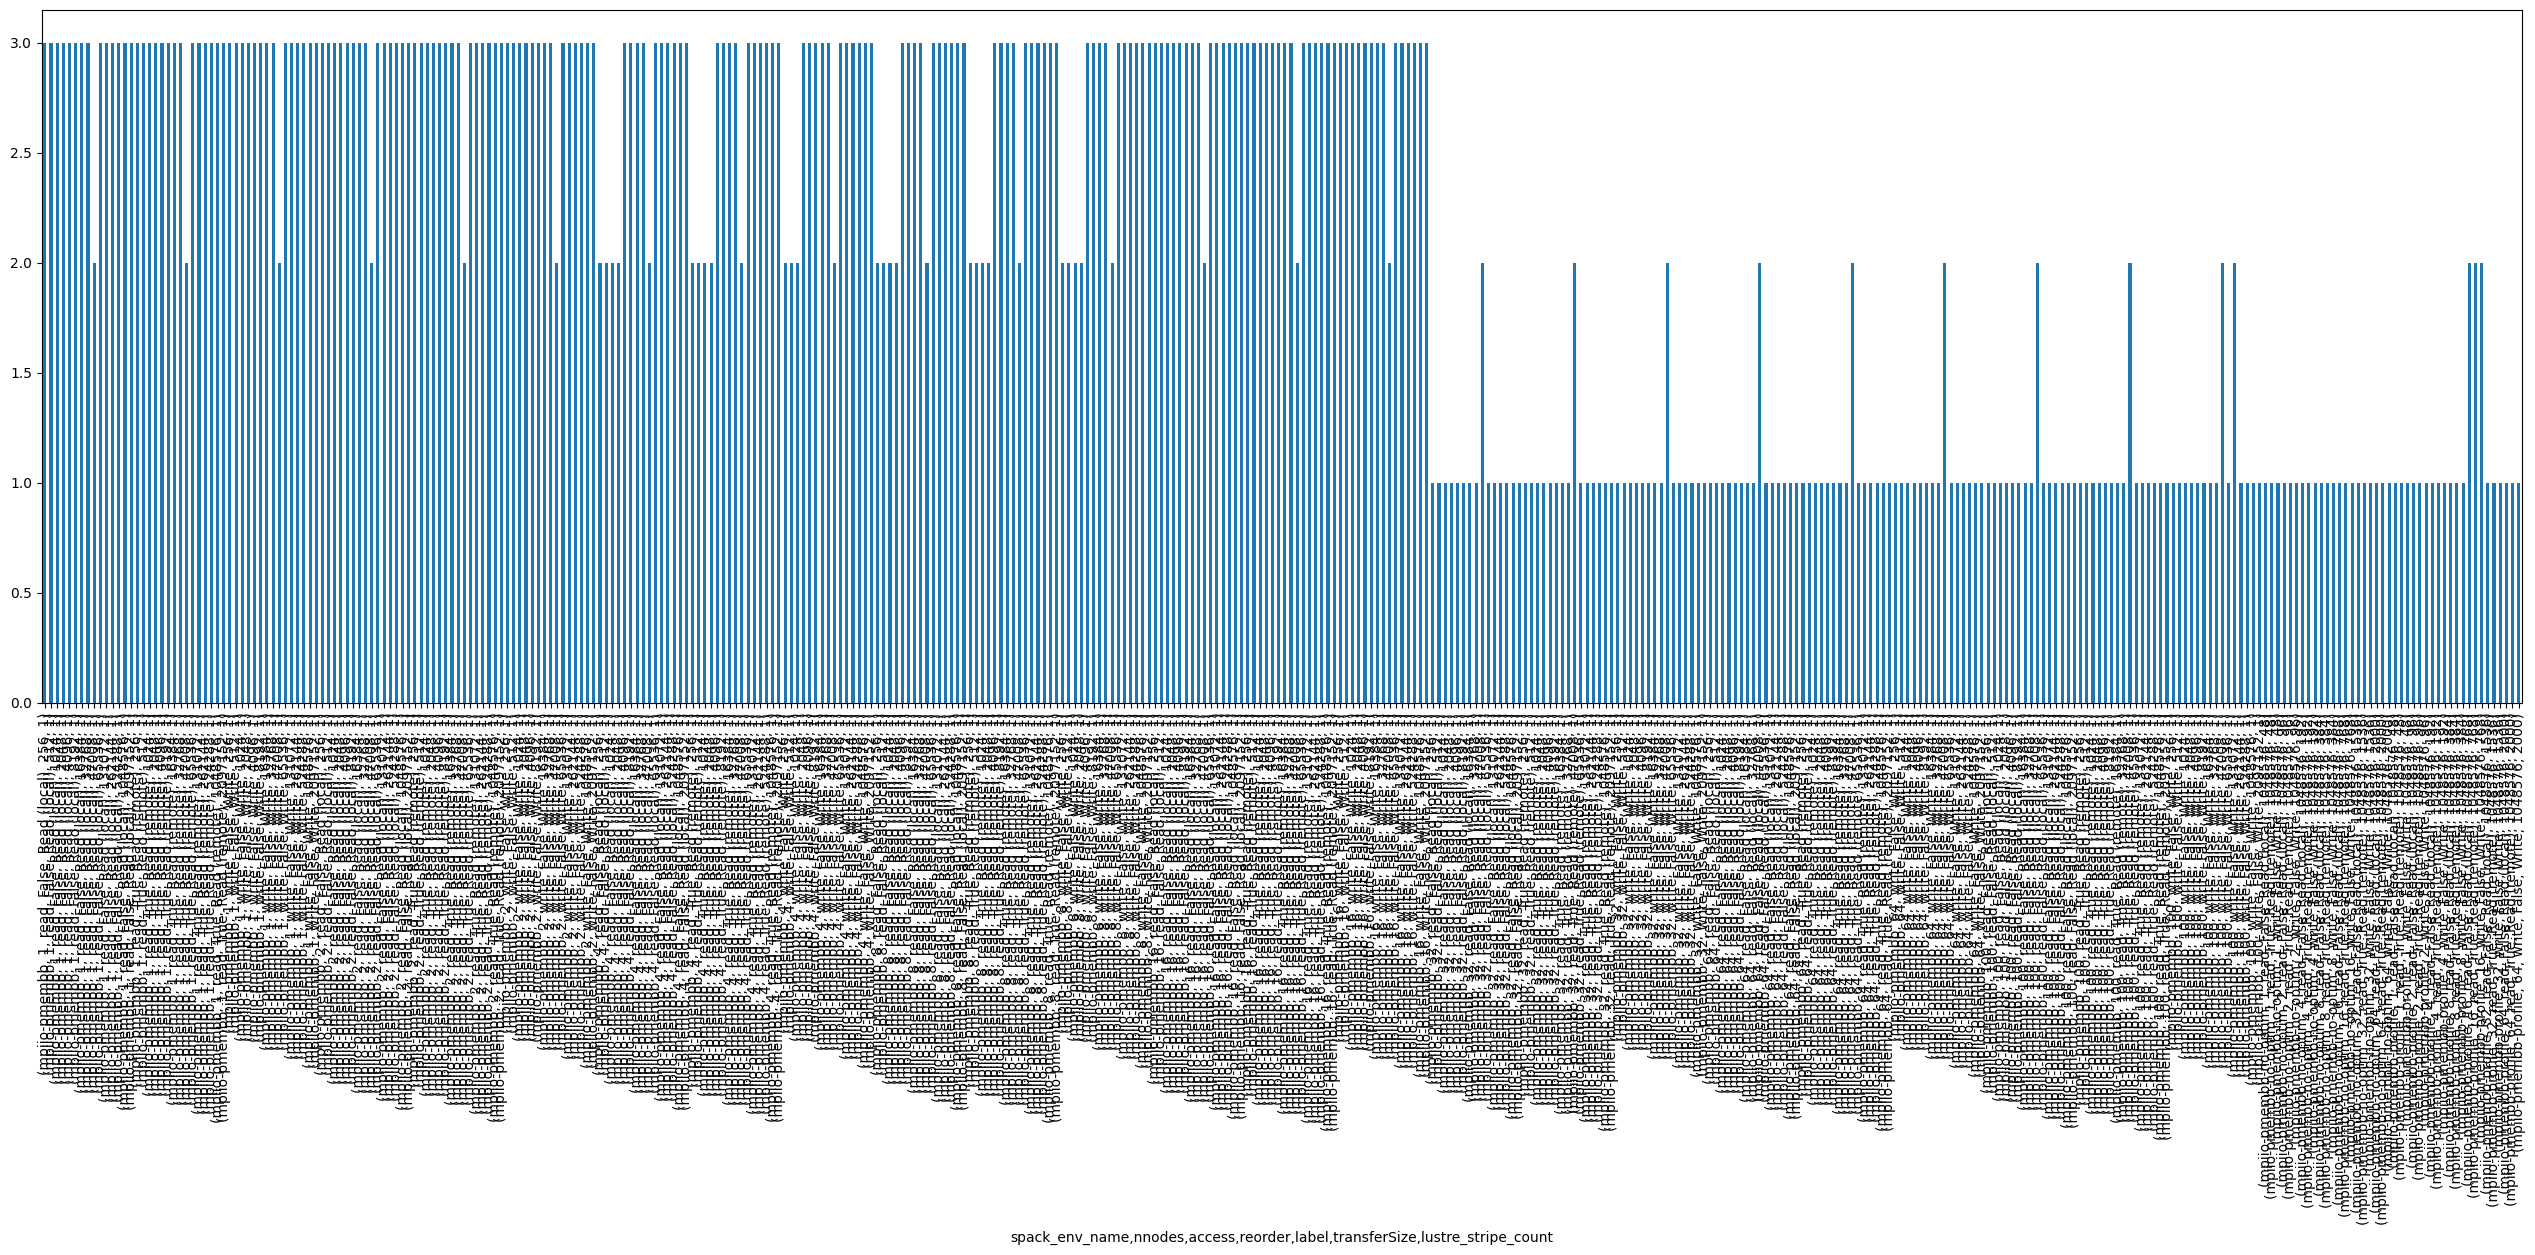

In [7]:
df = df_src
same_setting_columns = [
    "spack_env_name", "nnodes", "access", "reorder", "label", "transferSize", "lustre_stripe_count"]
same_setting_grouper = df.groupby(same_setting_columns)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# display(same_setting_grouper.size())
(
    same_setting_grouper
    .size()
    .plot(figsize=(32, 9), kind="bar")
)


In [8]:
{
  "mpiio-pmembb": "+deferred_open",
  "mpiio-pmembb-deferred-open": "+deferred_open",
  "mpiio-pmembb-agg-read": "baseline",
  "mpiio-pmembb-no-optim": "baseline",
}

{'mpiio-pmembb': '+deferred_open',
 'mpiio-pmembb-deferred-open': '+deferred_open',
 'mpiio-pmembb-agg-read': 'baseline',
 'mpiio-pmembb-no-optim': 'baseline'}

In [9]:

time_columns = ["openTime", "wrRdTime"]
same_setting_grouper[time_columns].mean().reset_index()["transferSize"].unique()#.query(f"access == 'write' and transferSize == {2**20}")

array([    256,     512,    1024,    2048,    4096,    8192,   16384,
         32768,   47008,   65536,  131072,  262144,  524288, 1048576,
       2097152])

write


'+deferred_open'

,openTimeMS
nnodes,
1,74.3
2,63.2
4,157.1
8,141.3
16,392.0
32,404.4
64,413.4


'baseline'

,openTimeMS
nnodes,
1,172.6
2,78.9
4,145.8
8,230.7
16,469.7
32,1547.1
64,4619.2


/tmp/ipykernel_10065/4208229112.py:77: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


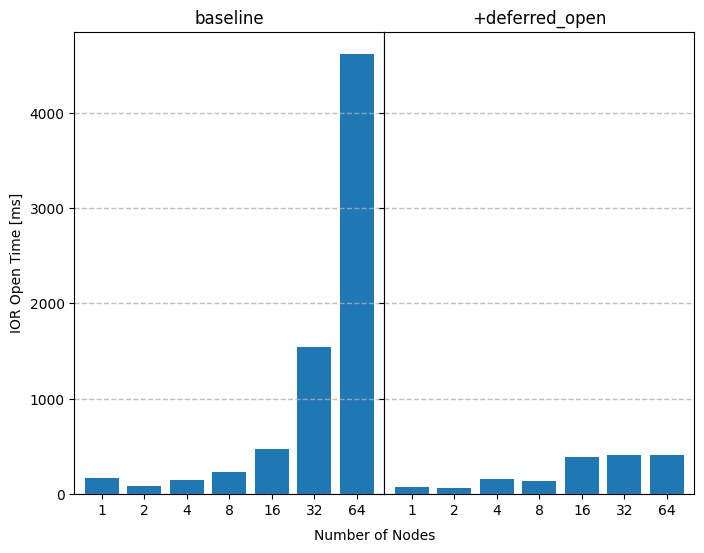

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [10]:
env_to_label = {
  "mpiio-pmembb": "+deferred_open",
  "mpiio-pmembb-deferred-open": "+deferred_open",
  "mpiio-pmembb-agg-read": "baseline",
  "mpiio-pmembb-no-optim": "baseline",
  "mpiio-pmembb-profile": "+deferred_open"
}

time_columns = ["openTime", "wrRdTime", "closeTime", "totalTime", "createTime", "loadTime", "saveTime", "freeTime"]

df = (
    same_setting_grouper
    [time_columns]
    .max()
    .reset_index()
    .assign(transferSizeH=lambda x: x["transferSize"].apply(pretty_fmt))
    .assign(optim=lambda x: x["spack_env_name"].apply(lambda y: env_to_label[y]))
    .query(f"lustre_stripe_count != 1")
    .query(f"not (access == 'read' and reorder == True and nnodes == 1) and not (access == 'read' and reorder == False) and transferSize == {2**20} and nnodes <= 64")
    .query("access == 'write'")
    .fillna(0.)
)
# df

for timec in time_columns:
    df[f"{timec}MS"] = df[timec] * 1000

for (access, ), df_access in df.groupby(["access"]):
    print(access)
    # if access == "write":
        # time_values = ["createTime", "openTime", "wrRdTime", "closeTime", "saveTime", "freeTime"]
        # time_values = ["loadTime", "openTime", "wrRdTime", "closeTime", "saveTime"]
    # else:
        # time_values = ["createTime", "loadTime", "openTime", "wrRdTime", "closeTime", "freeTime"]
        # time_values = ["loadTime", "openTime", "wrRdTime", "closeTime", "saveTime"]
    time_values = ["openTimeMS"]

    fig, axs = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
    fig.patch.set_alpha(1)
    fig.subplots_adjust(hspace=0, wspace=0)

    for idx, ((optim, ), df_sub) in enumerate(df_access.groupby(["optim"])):
        # display(df_sub)
        df_plot = (
            df_sub
            .set_index("nnodes")
            [time_values]
            # .loc[["baseline", "+deferred_open"], :]
        )
        display(optim, df_plot)

        # fig = plt.figure(figsize=(8, 6), dpi=100)
        # fig.patch.set_alpha(1)
        ax = df_plot.plot(
            ax=axs[(idx+1)%2],
            kind="bar",
            stacked=True,
            xlabel="",
            ylabel="IOR Open Time [ms]",
            # style=".-",
            legend=None,
            rot=0,
            width=0.8,
        )
        ax.set_title(f"{optim}")
        ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)
        # handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
        # ax.legend(title='nnodes', handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示
        # ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))


    # handles, labels = ax.get_legend_handles_labels()
    # fig.legend(handles=handles[::-1], labels=labels[::-1], loc="upper right", bbox_to_anchor=(0.99, 0.89))#, borderaxespad=0.)
    
    fig.text(0.5, 0.04, "Number of Nodes", ha="center", va="center")

    fig.show()
    plt.show()
    save(fig, F"ior_deffered_open_{access}")

transferSizeH,256B,512B,1KB,2KB,4KB,8KB,16KB,32KB,47008B,64KB,128KB,256KB,512KB,1MB,2MB
nnodes,,,,,,,,,,,,,,,
1,59.937796,69.043245,68.590326,69.465175,76.338659,80.478184,81.830313,82.759076,82.159474,82.921406,83.200613,83.491632,83.593321,82.650955,72.410097
2,119.938596,139.482530,140.211936,140.756915,154.256532,162.822235,166.431911,167.684872,163.665659,169.125535,169.882509,168.711783,169.819335,168.095379,147.117471
4,234.150514,268.633205,275.360832,275.415709,299.782369,317.136574,321.370639,325.069035,325.034212,326.613110,327.803015,328.201745,328.375277,326.189937,284.807355
8,464.785043,537.723202,545.967425,552.347780,597.861130,626.206973,635.562124,648.126400,646.200201,649.463634,654.396892,651.531949,651.082264,645.097860,566.031306
16,911.391293,1068.261470,1083.172753,1086.242740,1189.896360,1256.471741,1268.877118,1283.556422,1281.530173,1283.088861,1276.106926,1293.216576,1303.361282,1281.268593,1115.760961
32,1811.834229,2109.782500,2152.598944,2141.145805,2337.090638,2486.218370,2463.978950,2546.018171,2545.508961,2545.860828,2510.047941,2544.071139,2550.720071,2548.126221,2209.531380
64,3624.566264,4213.781161,4280.375483,4293.161774,4662.839176,4892.790739,5010.175516,5073.063752,5058.711286,5030.160458,4818.607626,5102.304544,5139.174919,4990.550762,4400.692407
100,5479.364182,6442.494305,6530.482860,6772.440746,7039.808650,7424.626788,7527.117014,7686.149692,7644.985414,7740.061536,7750.595630,7617.305227,7722.492855,7531.998260,6698.951860


[0 1 2 3 4 5 6 7]


/tmp/ipykernel_10065/1007818254.py:100: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


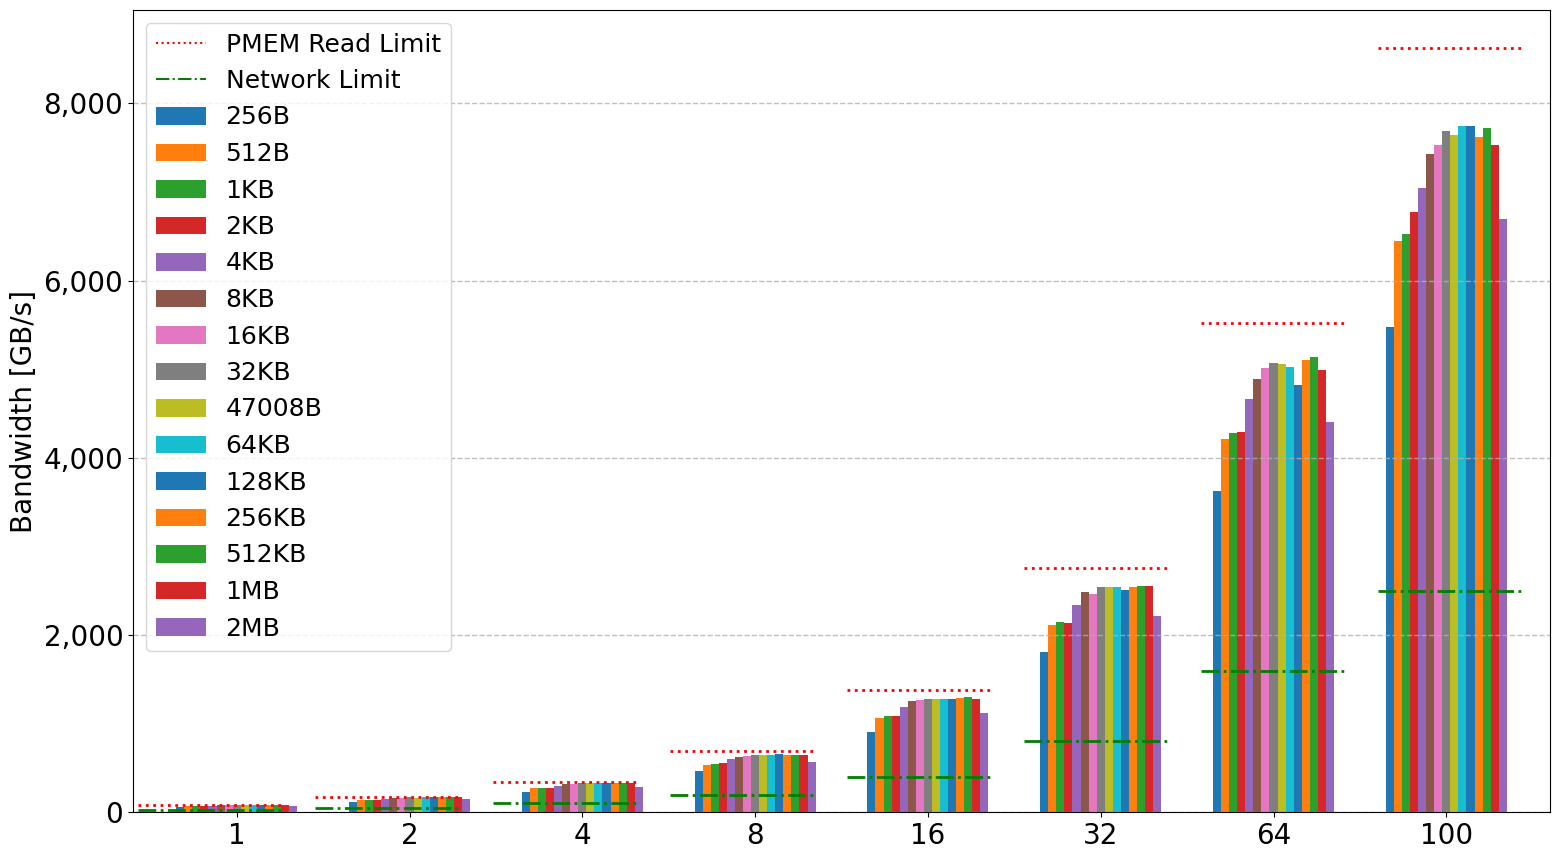

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


transferSizeH,256B,512B,1KB,2KB,4KB,8KB,16KB,32KB,47008B,64KB,128KB,256KB,512KB,1MB,2MB
nnodes,,,,,,,,,,,,,,,
2,4.887663,9.309238,17.252629,31.216620,44.116229,47.178962,47.957393,48.437253,48.482843,48.522570,48.568824,48.548412,48.580417,48.577650,48.578961
4,9.196967,17.511601,27.819040,55.099902,86.048086,94.261050,95.743169,96.725825,95.566129,96.025318,96.939422,97.089789,96.910504,96.951911,96.945178
8,16.257175,30.837754,52.315632,101.281132,171.186583,187.906674,191.444053,193.212062,190.675000,191.722674,193.701077,193.858457,193.848517,193.775742,193.637612
16,35.857595,68.024477,108.352224,218.958258,342.805684,375.345327,382.671262,386.295563,381.648661,384.274221,386.941289,386.758058,387.072398,386.819969,386.882161
32,61.436965,116.414096,192.563174,383.170215,636.516599,736.027829,759.598960,769.056710,760.637662,766.485555,768.784026,773.253691,772.035052,771.867374,770.055386
64,122.353868,232.120670,383.284577,772.236503,1279.679655,1489.254594,1522.365739,1537.975750,1519.374561,1524.865183,1539.120074,1541.638842,1537.505153,1540.232576,1540.631507
100,192.169223,365.171100,605.677897,1179.059970,1960.132553,2290.634927,2344.225928,2382.250783,2360.679532,2359.441943,2379.961711,2387.744699,2384.772966,2381.713974,2385.701405


/tmp/ipykernel_10065/1007818254.py:100: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[0 1 2 3 4 5 6]


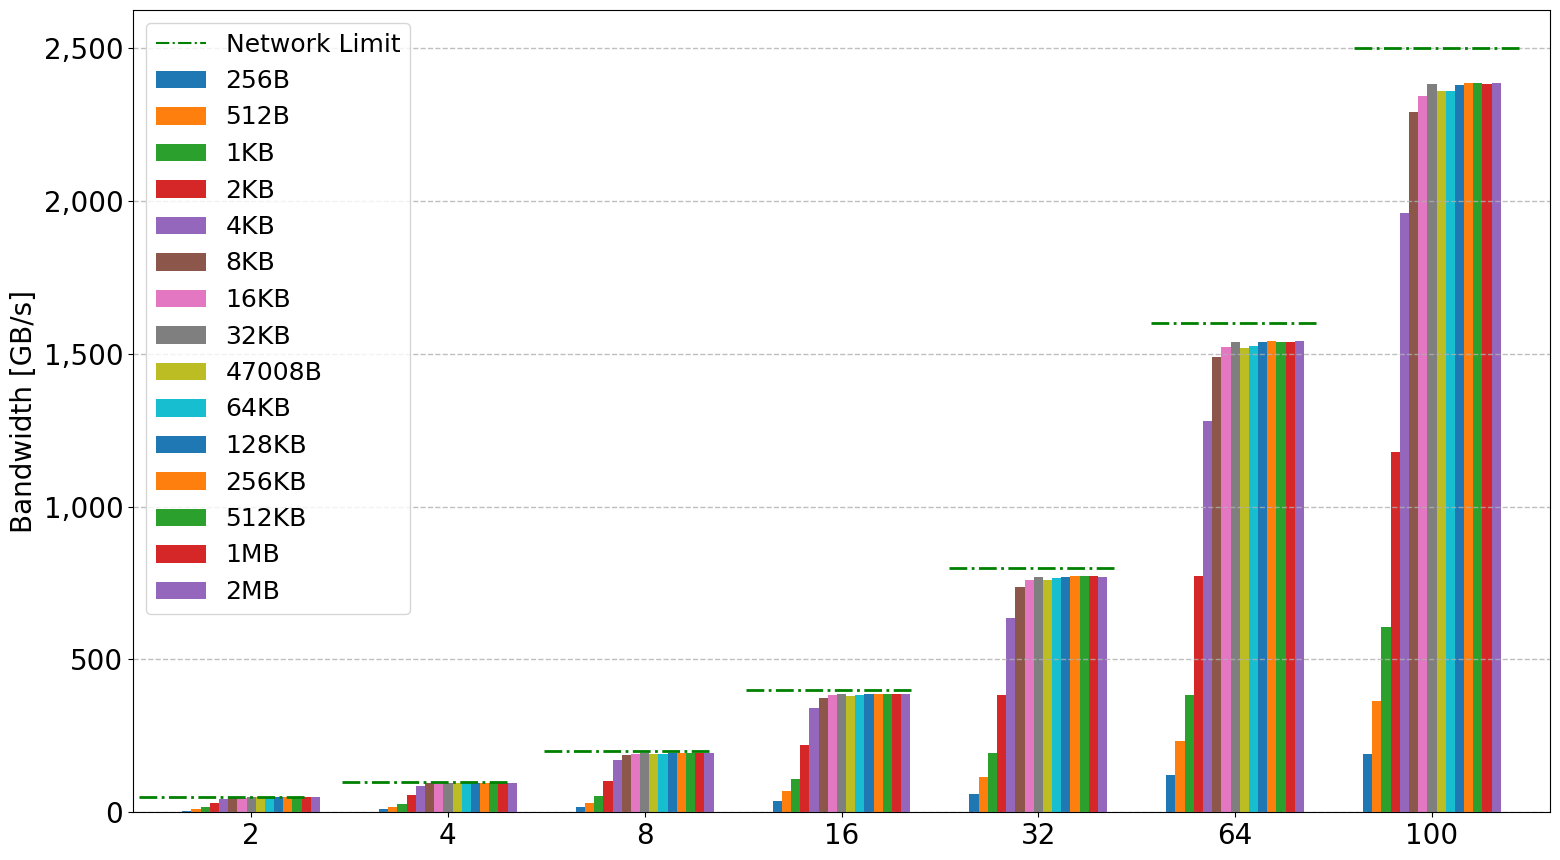

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


transferSizeH,256B,512B,1KB,2KB,4KB,8KB,16KB,32KB,47008B,64KB,128KB,256KB,512KB,1MB,2MB
nnodes,,,,,,,,,,,,,,,
1,26.309229,26.470330,26.261931,26.210188,25.861533,25.107555,25.016613,24.969357,24.405955,25.060271,24.991053,25.017081,24.987864,25.016087,25.594842
2,52.662124,52.864778,52.591439,52.308009,51.740618,50.263043,50.051812,49.739472,48.931415,50.117499,49.972404,50.045342,49.983904,49.800519,51.164929
4,102.783174,102.664157,102.667894,103.653041,102.497893,99.700032,99.313193,99.027769,97.518366,99.604441,99.354583,99.270554,99.244070,99.503459,101.575146
8,197.806874,199.337269,199.326204,200.393265,201.975732,197.858709,194.981057,196.817743,194.343510,197.690614,197.231901,197.348567,197.349616,197.149034,201.308884
16,394.192824,396.783696,398.384713,398.962319,396.062140,389.704063,389.283534,388.792888,388.167277,389.390406,389.563799,388.621930,389.222869,389.262743,394.061112
32,787.182607,792.990882,797.220423,799.270147,794.042560,778.365695,773.940748,776.469187,775.017661,776.741828,774.380148,775.142041,776.522630,775.872119,790.893819
64,1557.042196,1582.708532,1588.982252,1594.014120,1577.847059,1547.341789,1546.420566,1540.161204,1535.153949,1546.250892,1543.979352,1536.456955,1543.428012,1544.112552,1562.943721
100,2401.679537,2462.997753,2470.947638,2465.055903,2463.853422,2417.993880,2408.448315,2411.629479,2388.702330,2414.653564,2408.929476,2405.065374,2408.673904,2406.934527,2429.826425


/tmp/ipykernel_10065/1007818254.py:100: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[0 1 2 3 4 5 6 7]


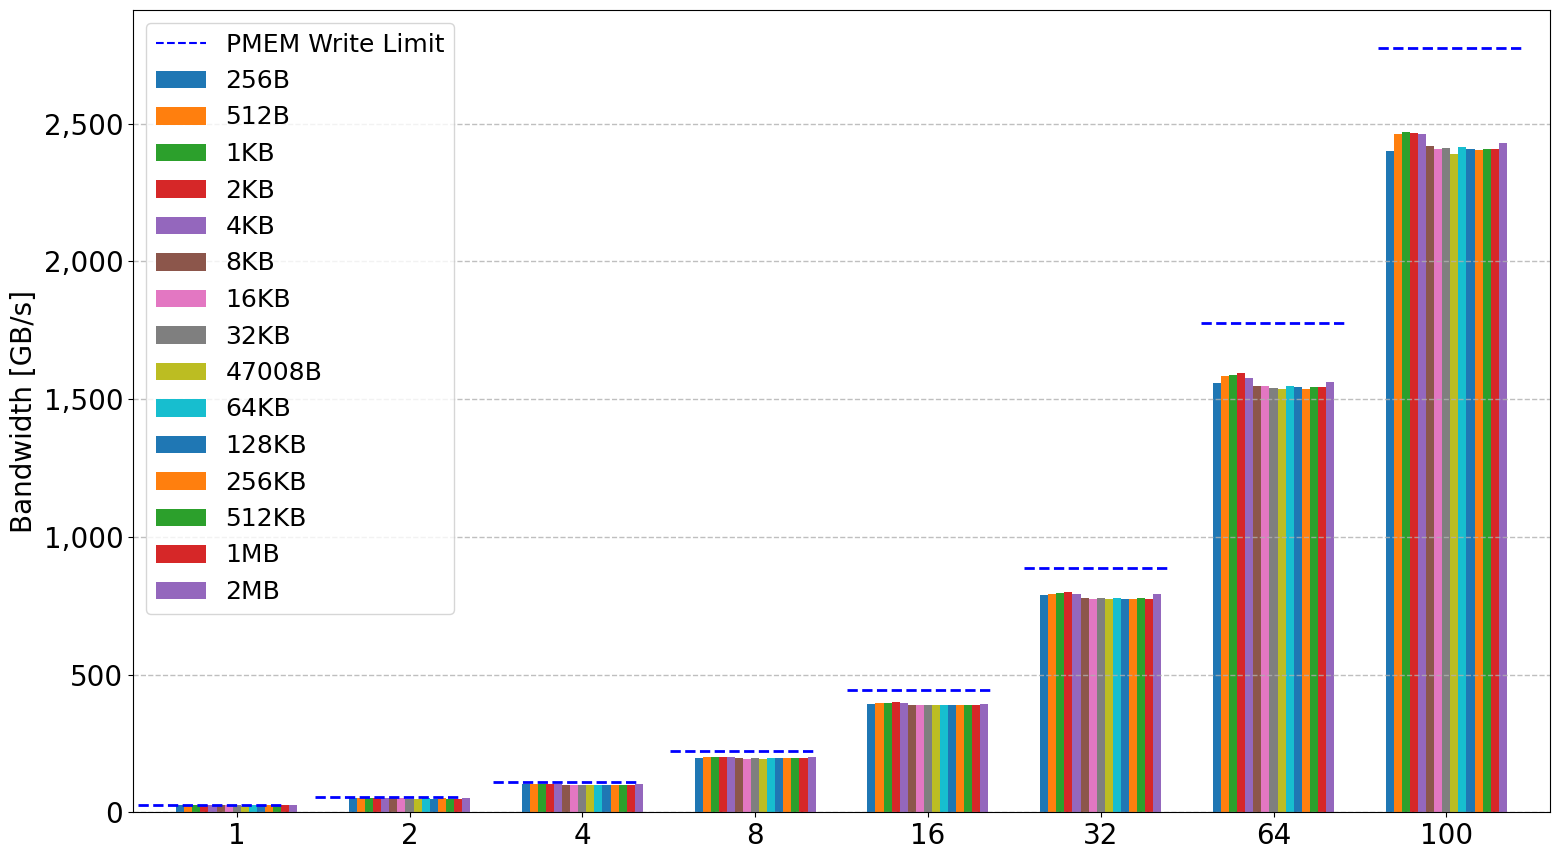

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [25]:
plt.rcParams.update({'font.size': 20})

def network_limit(nnodes, bandwidth_per_node=25):
    return nnodes * bandwidth_per_node

PMEM_READ_LIMIT_PER_NODE = 80.309346 * 2**30 / 10**9
PMEM_WRITE_LIMIT_PER_NODE = 25.836094 * 2**30 / 10**9

def pmem_read_limit(nnodes):
    return nnodes * PMEM_READ_LIMIT_PER_NODE

def pmem_write_limit(nnodes):
    return nnodes * PMEM_WRITE_LIMIT_PER_NODE

df = (
    same_setting_grouper["bwGB"].max()
    # .agg({
    #     "bw": "max",
    #     "time": "min",
    # })
    .reset_index()
    # .assign(bwGB=lambda x: x["bw"] * 2**20 / 10**9)
    .assign(transferSizeH=lambda x: x["transferSize"].apply(to_human))
    .query("lustre_stripe_count == 1")
    .query("spack_env_name == 'mpiio-pmembb' and not (access == 'read' and reorder == True and nnodes == 1)")
)

xfer_order = [pretty_fmt(256 * 2**x) for x in range(0, 14)]
xfer_order.insert(8, "47008B")

for (access, reorder, label), df_sub, in df.groupby(["access", "reorder", "label"]):
    # for value in ["bw", "time"]:
    for value in ["bwGB"]:
        # df_plot = df_sub.pivot(index="transferSize", columns=["nnodes"], values=value)
        df_plot = df_sub.pivot(index="nnodes", columns=["transferSizeH"], values=value).loc[:, xfer_order]

        display(df_plot)

        fig = plt.figure(figsize=(16, 9), dpi=100)
        fig.patch.set_alpha(1)
        # ax=fig.add_subplot()

        ax = df_plot.plot(
            ax=fig.add_subplot(),
            kind="bar",
            # kind="line",
            # xlabel="Transfer size [B]",
            # xlabel="Number of nodes",
            xlabel="",
            ylabel="Bandwidth [GB/s]" if value == "bwGB" else "Elapsed time [sec]",
            # style=".-",
            rot=0,
            width=0.7,
        )
        # if reorder:
        # バーグラフのx軸の目盛りの位置を取得
        xticks = ax.get_xticks()
        print(xticks)
        
        # ノード数に対応するネットワーク帯域幅の限界値を計算
        network_limits = [network_limit(nnodes) for nnodes in df_plot.index]
        pmem_read_limits = [pmem_read_limit(nnodes) for nnodes in df_plot.index]
        pmem_write_limits = [pmem_write_limit(nnodes) for nnodes in df_plot.index]
        
        # 各ノード数に対してネットワーク帯域幅の限界線をプロット
        # for xtick, limit in zip(xticks, network_limits):
        #     ax.axhline(y=limit, xmin=(xtick+0.1)/len(xticks), xmax=(xtick + 0.8)/len(xticks), color='red', linestyle='--', linewidth=1)
        
        # # 凡例にネットワーク限界線を追加
        # ax.plot([], [], linestyle="--", color="red", label="Network Limit")

        # 各ノード数に対して限界線をプロット
        if access == 'read' and reorder == False:
            for xtick, limit in zip(xticks, pmem_read_limits):
                ax.axhline(y=limit, xmin=(xtick+0.03)/len(xticks), xmax=(xtick + 0.85)/len(xticks), color='red', linestyle=':', linewidth=2)
            ax.plot([], [], linestyle=":", color="red", label="PMEM Read Limit")
        if access == 'write':
            for xtick, limit in zip(xticks, pmem_write_limits):
                ax.axhline(y=limit, xmin=(xtick+0.03)/len(xticks), xmax=(xtick + 0.85)/len(xticks), color='blue', linestyle='--', linewidth=2)
            ax.plot([], [], linestyle="--", color="blue", label="PMEM Write Limit")
        if access == 'read':
            for xtick, limit in zip(xticks, network_limits):
                ax.axhline(y=limit, xmin=(xtick+0.03)/len(xticks), xmax=(xtick + 0.85)/len(xticks), color='green', linestyle='-.', linewidth=2)
            ax.plot([], [], linestyle="-.", color="green", label="Network Limit")

        # ax.set_title(f"IOR {label}")
        # ax.set_xscale("log", base=2)
        # ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
        ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)
        # handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
        # ax.legend(title='nnodes', handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示
        ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))

        # legend_title = ax.get_legend().get_title().get_text()
        # ax.legend(title=legend_title, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
        # ax.legend(title="Transfer size")
        ax.legend(title="", fontsize=18)
        plt.tight_layout()

        fig.show()
        plt.show()
        save(fig, F"ior_{access}_{'remote' if reorder else 'local'}_{value}")
